In this notebook, I try to applied what I have learned in DeepLearning.AI's CNN course on Coursera. I used transfer learning with MobileNetV2 on the Doom vs Animal Crossing Dataset on Kaggle.

Doom and Animal Crossing are two computer games of different genres. The dataset consists of memes of the two games and the tasks is to classify which meme belongs to which game.

### Credit:
Dataset: https://www.kaggle.com/andrewmvd/doom-crossing
<br>
Convolution Neural Networks by DeepLearning.AI

To classify images in this task, I will be using pretrained model MobileNetv2 and fine tuning. 

# Import Libraries

First, I will import libraries that I will be using. For the classification task, I will use TensorFlow framework.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from textwrap import wrap
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from keras import callbacks

# Processing Data

## Load and split the dataset

Setting batch size, image size and getting the directory of the dataset.

In [24]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/kaggle/input/doom-crossing"

I will be dividing the dataset into train, validation and test dataset with ratio 8:1:1.

In [25]:
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)


Found 1597 files belonging to 2 classes.
Using 1278 files for training.
Found 1597 files belonging to 2 classes.
Using 319 files for validation.


In [26]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [27]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 40
Number of validation batches: 5
Number of test batches: 5


## Examples from dataset

Displaying some images in the dataset:

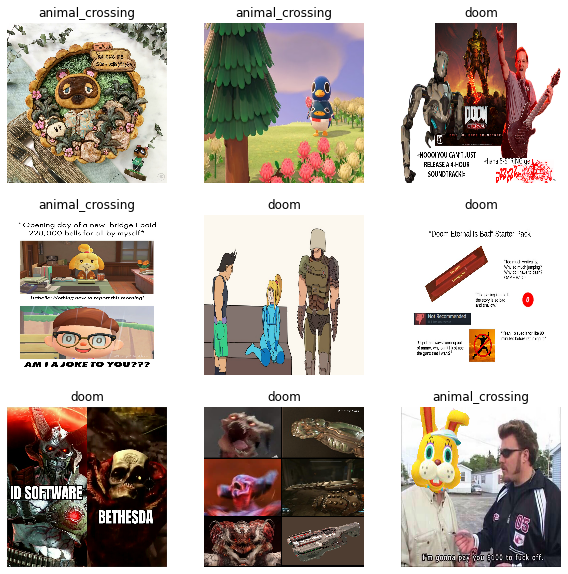

In [28]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

To optimize execution time, I will use prefetching.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

1278 files for training is quite few so I will augment data so as to gain more data.

In [30]:
def data_augmenter():
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

Displaying an example of a set of images augmented from 1 image:

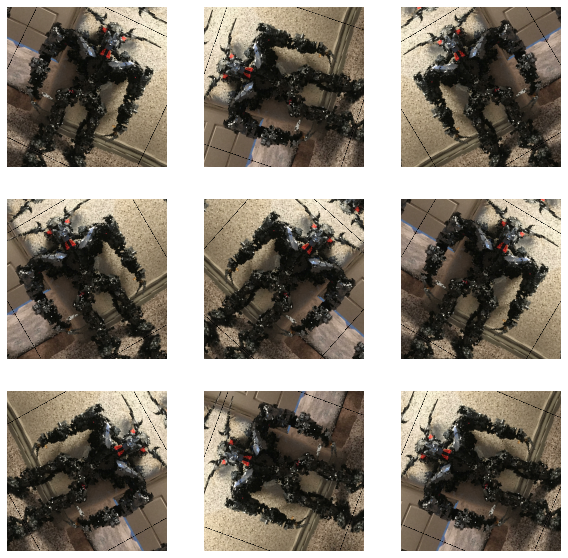

In [31]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Define a new model based on MobileNetV2 pretrained model

## Define the model

I will be using MobileNetV2 pretrained model, replacing the top layer with a Pooling, Dropout and Dense layers.

In [32]:
def my_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet') 
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(1)
     
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

I will use the preprocess input of MobileNetV2.

In [33]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [34]:
model = my_model(IMG_SIZE, data_augmentation)

Compile model with learning rate = 0.0001

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Setting an early stopping to prevent overfitting: 

In [36]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 3, 
                                        restore_best_weights = True)

## Train the model

In [37]:
initial_epochs = 15
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks = [earlystopping])

Epoch 1/15
40/40 [==============================] - 44s 1s/step - loss: 0.7416 - accuracy: 0.5947 - val_loss: 0.6166 - val_accuracy: 0.5849
Epoch 2/15
40/40 [==============================] - 44s 1s/step - loss: 0.6770 - accuracy: 0.5947 - val_loss: 0.5490 - val_accuracy: 0.7107
Epoch 3/15
40/40 [==============================] - 43s 1s/step - loss: 0.6203 - accuracy: 0.6385 - val_loss: 0.5044 - val_accuracy: 0.7421
Epoch 4/15
40/40 [==============================] - 53s 1s/step - loss: 0.5734 - accuracy: 0.6870 - val_loss: 0.5186 - val_accuracy: 0.7233
Epoch 5/15
40/40 [==============================] - 44s 1s/step - loss: 0.5387 - accuracy: 0.7128 - val_loss: 0.4705 - val_accuracy: 0.7547
Epoch 6/15
40/40 [==============================] - 44s 1s/step - loss: 0.5230 - accuracy: 0.7238 - val_loss: 0.4510 - val_accuracy: 0.7987
Epoch 7/15
40/40 [==============================] - 44s 1s/step - loss: 0.5009 - accuracy: 0.7379 - val_loss: 0.3893 - val_accuracy: 0.8239
Epoch 8/15
40/40 [==

## Evaluation

Visualizing the accuracy and loss on train and validation dataset.

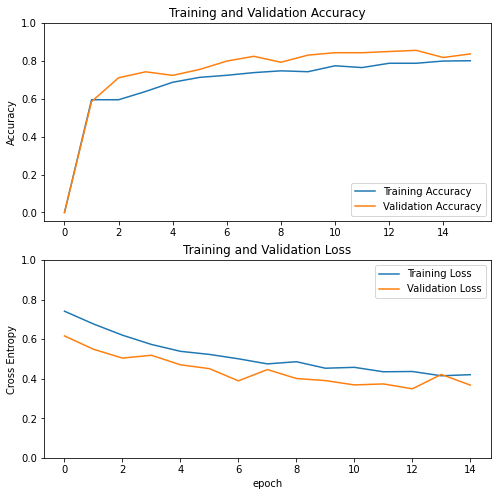

In [38]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

I will fine tune the model - keep some layers and modify some top layers.

In [39]:
print(model.layers)
base_model = model.layers[4]
base_model.trainable = True
# Number of layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.01 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1c48f852d0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f1c4a2996d0>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f1c4a34dd50>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f1c4a273c90>, <tensorflow.python.keras.engine.functional.Functional object at 0x7f1ca03e0950>, <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1ca050efd0>, <tensorflow.python.keras.layers.core.Dropout object at 0x7f1ca050b450>, <tensorflow.python.keras.layers.core.Dense object at 0x7f1ca05a6710>]
Number of layers in the base model:  155


In [40]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks= [earlystopping])

Epoch 15/30
40/40 [==============================] - 56s 1s/step - loss: 0.4103 - accuracy: 0.7856 - val_loss: 0.3087 - val_accuracy: 0.8742
Epoch 16/30
40/40 [==============================] - 49s 1s/step - loss: 0.3933 - accuracy: 0.8122 - val_loss: 0.3745 - val_accuracy: 0.8553
Epoch 17/30
40/40 [==============================] - 49s 1s/step - loss: 0.3827 - accuracy: 0.8106 - val_loss: 0.3959 - val_accuracy: 0.8050
Epoch 18/30
40/40 [==============================] - 49s 1s/step - loss: 0.3745 - accuracy: 0.8208 - val_loss: 0.3152 - val_accuracy: 0.8868
Epoch 19/30
40/40 [==============================] - 49s 1s/step - loss: 0.3692 - accuracy: 0.8333 - val_loss: 0.2864 - val_accuracy: 0.8742
Epoch 20/30
40/40 [==============================] - 51s 1s/step - loss: 0.3730 - accuracy: 0.8216 - val_loss: 0.3160 - val_accuracy: 0.8679
Epoch 21/30
40/40 [==============================] - 50s 1s/step - loss: 0.3654 - accuracy: 0.8279 - val_loss: 0.3213 - val_accuracy: 0.8679


## Evaluation

Plotting the accuracy and loss of train and validation set agains epochs with a mark of start fine tuning:

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

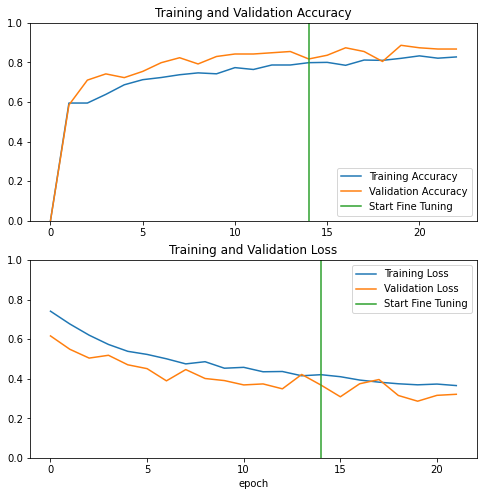

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate on test set

Applying the model on test set to see its accuracy on a totally separated image set:

In [43]:
loss, accuracy = model.evaluate(test_dataset)

5/5 [==============================] - 2s 398ms/step - loss: 0.4070 - accuracy: 0.8438


I try adjusting some hyperparameters such as learning rate, number of fine-tuning layers, number of epochs, batch size... 
However, the accuracy on validation and test set does not vary much.

Display misclassified images:

Predictions:
 [0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0]
Labels:
 [0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0]
Predictions:
 [1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0]
Labels:
 [1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0]
Predictions:
 [0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0]
Labels:
 [0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0]
Predictions:
 [1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1]
Labels:
 [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0]
Predictions:
 [1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0]
Labels:
 [1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0]


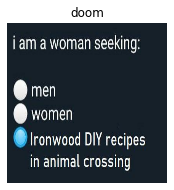

<Figure size 720x720 with 0 Axes>

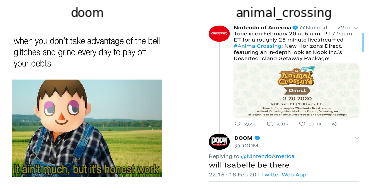

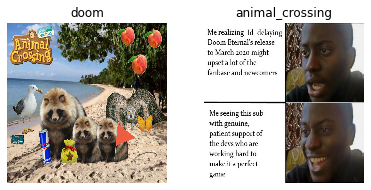

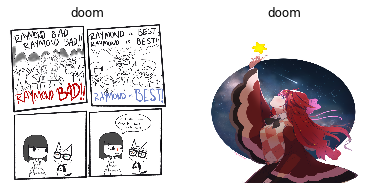

In [44]:
#Retrieve a batch of images from the test set
for batch in list(test_dataset.as_numpy_iterator()):
    image_batch, label_batch = batch
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    diff= predictions- label_batch
    diff_idx=[]
    for i in range(16):
        if diff[i]!=0:
            diff_idx.append(i)
    print('Predictions:\n', predictions.numpy())
    print('Labels:\n', label_batch)

    plt.figure(figsize=(10, 10))
    for i in range(len(diff_idx)):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[diff_idx[i]].astype("uint8"))
      plt.title(class_names[predictions[diff_idx[i]]])
      plt.axis("off")

Looking at the misclassified images, I think the model can be further improve by recoginizing texts in images.
For example, some animal crossing memes with texts that even include "animal crossing" are now still classified as doom. 
<br>
Hence, if texts can be extract and analyzed, the accuracy should improve.